In [1]:
# 1. Import required libraries
# Import data handling and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import model selection and evaluation utilities
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [2]:
# 2. Load train and test data
df_train = pd.read_csv(r"C:\Users\11\Documents\Machine Learning\09 Projects\03 Titanic Classification\Dataset\train.csv")
df_test = pd.read_csv(r"C:\Users\11\Documents\Machine Learning\09 Projects\03 Titanic Classification\Dataset\test.csv")

In [3]:
# 3. Inspect data
print("=== TRAIN HEAD ===")
print(df_train.head())
print("\n=== TRAIN INFO ===")
print(df_train.info())
print("\n=== TRAIN NULL COUNTS ===")
print(df_train.isnull().sum())

print("\n=== TEST HEAD ===")
print(df_test.head())
print("\n=== TEST INFO ===")
print(df_test.info())
print("\n=== TEST NULL COUNTS ===")
print(df_test.isnull().sum())

=== TRAIN HEAD ===
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500 

In [4]:
# 4. Define preprocessing function
def preprocess_data(df):
    # Fill missing Embarked with mode
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Fill missing Age with median (simple imputation)
    df['Age'] = df['Age'].fillna(df['Age'].median())

    # Fill missing Fare with median if present
    if 'Fare' in df.columns:
        df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # Extract title from Name
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major',
         'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

    # Extract cabin letter if available (first character), else 'Unknown'
    df['CabinLetter'] = df['Cabin'].astype(str).str[0].replace('n', 'Unknown')

    # Extract ticket prefix if exists (non-numeric part), else 'None'
    def ticket_prefix(ticket):
        parts = ticket.replace('.', '').replace('/', '').split()
        prefixes = [p for p in parts if not p.isdigit()]
        if len(prefixes) == 0:
            return 'None'
        else:
            return prefixes[0]
    df['TicketPrefix'] = df['Ticket'].astype(str).apply(ticket_prefix)

    # Create FamilySize and IsAlone
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Create fare bin (simple bucketing)
    df['FareBin'] = pd.qcut(df['Fare'], 4, labels=False, duplicates='drop')

    # Map Sex to numeric
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})

    # Drop columns that we will not use directly
    drop_cols = ['Name', 'Ticket', 'Cabin']
    for c in drop_cols:
        if c in df.columns:
            df.drop(c, axis=1, inplace=True)

    # One-hot encode categorical variables
    cat_cols = ['Embarked', 'Title', 'CabinLetter', 'TicketPrefix', 'FareBin']
    existing_cat_cols = [c for c in cat_cols if c in df.columns]
    df = pd.get_dummies(df, columns=existing_cat_cols, drop_first=True)

    return df

In [5]:
# 5. Apply preprocessing to both train and test, then align columns
df_train_p = preprocess_data(df_train.copy())
df_test_p = preprocess_data(df_test.copy())

# Ensure the test set has same columns as train (add missing columns with zeros)
train_cols = df_train_p.columns.tolist()
# If 'Survived' is in train_cols keep it, but for X we drop it later
for c in train_cols:
    if c not in df_test_p.columns:
        df_test_p[c] = 0

# Some columns may be in test but not in train; drop them
for c in df_test_p.columns:
    if c not in train_cols:
        df_test_p.drop(c, axis=1, inplace=True)

# Reorder test columns to match train
df_test_p = df_test_p[train_cols]

In [6]:
# 6. Prepare data for training
# Separate features and target
X = df_train_p.drop('Survived', axis=1)
y = df_train_p['Survived']

# Train-validation split with stratification to preserve class proportions
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
# 7. Hyperparameter tuning using GridSearchCV
# We will search for a small grid of reasonable hyperparameters for GradientBoostingClassifier

param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.02, 0.06, 0.11],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gbr = GradientBoostingClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='f1',   # we focus on F1 to balance precision and recall
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV score (F1):", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params: {'learning_rate': 0.02, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score (F1): 0.7655417234001167


In [8]:
# 8. Train final model with best parameters on full training fold (X_train)
best_params = grid_search.best_params_
final_model = GradientBoostingClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Optionally retrain on full data (train+val) before final predictions
# X_full = pd.concat([X_train, X_val], axis=0)
# y_full = pd.concat([y_train, y_val], axis=0)
# final_model.fit(X_full, y_full)

,loss,'log_loss'
,learning_rate,0.02
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


In [9]:
# 9. Evaluate on validation set
y_val_pred = final_model.predict(X_val)
y_val_proba = final_model.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_val_pred)
roc = roc_auc_score(y_val, y_val_proba)
print("Validation Accuracy:", acc)
print("Validation ROC-AUC:", roc)
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7988826815642458
Validation ROC-AUC: 0.8515151515151517

Confusion Matrix:
 [[95 15]
 [21 48]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



Top 20 features:
 Title_Mr               0.429804
Fare                   0.107556
Pclass                 0.103017
Age                    0.069142
FamilySize             0.062349
PassengerId            0.048493
CabinLetter_Unknown    0.047568
Title_Other            0.038964
TicketPrefix_STONO     0.016237
Embarked_S             0.012285
CabinLetter_E          0.008329
CabinLetter_D          0.006518
TicketPrefix_SWPP      0.006504
TicketPrefix_SOPP      0.006423
TicketPrefix_None      0.005988
FareBin_1              0.004930
SibSp                  0.003236
TicketPrefix_A5        0.002826
Title_Mrs              0.002636
Embarked_Q             0.002525
dtype: float64


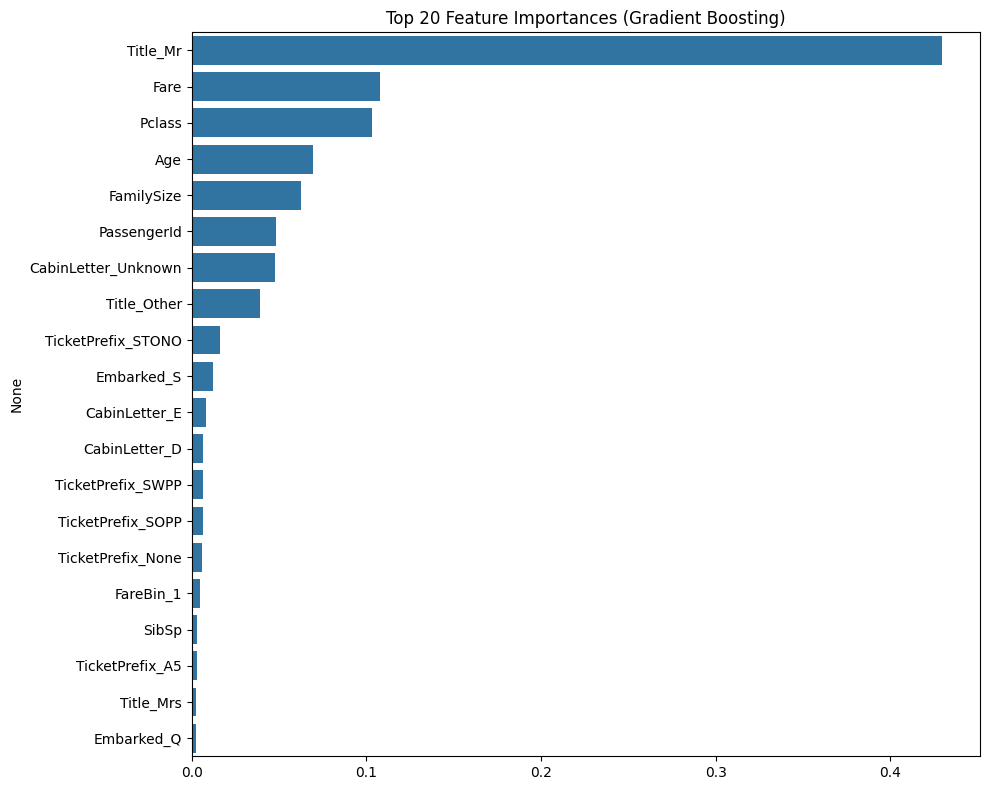

In [10]:
# 10. Feature importance
importances = pd.Series(final_model.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)

# Print top 20 features
print("Top 20 features:\n", importances_sorted.head(20))

# Plot
plt.figure(figsize=(10,8))
sns.barplot(x=importances_sorted.values[:20], y=importances_sorted.index[:20])
plt.title("Top 20 Feature Importances (Gradient Boosting)")
plt.tight_layout()
plt.show()

In [11]:
# 11. Predict on test data and save submission
# Remove 'Survived' if exists in test columns (it might have been added earlier as zero)
if 'Survived' in df_test_p.columns:
    X_test_final = df_test_p.drop('Survived', axis=1)
else:
    X_test_final = df_test_p.copy()

# Ensure column order matches training features
X_test_final = X_test_final[X_train.columns]

# Predict
test_preds = final_model.predict(X_test_final)

# Prepare submission
if 'PassengerId' in df_test.columns:
    passenger_ids = df_test['PassengerId']
else:
    passenger_ids = np.arange(len(df_test)) + 1

submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': test_preds
})

submission.to_csv('submission_gb.csv', index=False)
print("Saved submission to 'submission_gb.csv'")

Saved submission to 'submission_gb.csv'
